In [1]:
import pandas as pd
from py3dbp import Packer, Bin, Item
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')

#load from excel
boxes = pd.read_excel('input.xlsx', sheet_name='MASTER DATA')
qty_to_ship = pd.read_excel('input.xlsx', sheet_name='Sheet3')
qty_to_ship['TOTAL CARTONS TO SHIP'] = qty_to_ship['TOTAL CARTONS TO SHIP'].astype(int)
#parsing box dimensions from boxtemplate
dimensions = boxes['CARTON SIZE (inch)'].str.split(r'(\S+).x.(\S+).x.(\S+)', n=-1, expand=True)
dimensions.columns = ['','L','W','H','']
boxes = boxes.merge(dimensions, how="inner", left_index=True, right_index=True)
boxes['D'] = boxes['L'].astype(float)
boxes['W'] = boxes['W'].astype(float)
boxes['H'] = boxes['H'].astype(float)
qty_to_ship = qty_to_ship.merge(boxes[['ASIN', 'CARTON SIZE (inch)', 'W', 'H', 'D', 'WEIGHT PER CARTON (lb)']], how='left', on='ASIN')

#Check all skus
for sku in range(len(qty_to_ship)):
    boxes_qty = 0
    while boxes_qty < qty_to_ship.iloc[sku]['TOTAL CARTONS TO SHIP'] :
        #packer.add_item(Item(str(qty_to_ship.iloc[sku]['ASIN']) + ' box number ' + str(boxes_qty+1), qty_to_ship.iloc[sku]['L'], qty_to_ship.iloc[sku]['W'], qty_to_ship.iloc[sku]['H'], qty_to_ship.iloc[sku]['WEIGHT PER CARTON (lb)']))
        boxes_qty += 1
    #else: 
        #print('added ', boxes_qty, ' boxes of ASIN ', str(qty_to_ship.iloc[sku]['ASIN']))
print('Total SKUs will be loaded ', len(qty_to_ship))        

#make initial boxes list from sku df
def create_boxes_df_from_sku_df(qty_to_ship):
    for sku in range(len(qty_to_ship)):
        boxes_qty = 0
        while boxes_qty < qty_to_ship.iloc[sku]['TOTAL CARTONS TO SHIP'] :
            if boxes_qty < 1 and sku < 1:
                boxes_list = pd.DataFrame({"ASIN" : [qty_to_ship.iloc[sku]['ASIN']], "Box_name" : ['ASIN: ' + str(qty_to_ship.iloc[sku]['ASIN']) + ', box Template: ' + str(qty_to_ship.iloc[sku]['CARTON SIZE (inch)']) + ', box №' + str(boxes_qty+1)], "Box W" : [qty_to_ship.iloc[sku]['W']], "Box H" : [qty_to_ship.iloc[sku]['H']], "Box D" : [qty_to_ship.iloc[sku]['D']], "Box weight" : [qty_to_ship.iloc[sku]['WEIGHT PER CARTON (lb)']]})
            else:
                boxes_list = pd.concat([boxes_list, pd.DataFrame({"ASIN" : [qty_to_ship.iloc[sku]['ASIN']], "Box_name" : ['ASIN: ' + str(qty_to_ship.iloc[sku]['ASIN']) + ', box Template: ' + str(qty_to_ship.iloc[sku]['CARTON SIZE (inch)']) + ', box №' + str(boxes_qty+1)], "Box W" : [qty_to_ship.iloc[sku]['W']], "Box H" : [qty_to_ship.iloc[sku]['H']], "Box D" : [qty_to_ship.iloc[sku]['D']], "Box weight" : [qty_to_ship.iloc[sku]['WEIGHT PER CARTON (lb)']]})])
            boxes_qty += 1
        #else: 
            #print('added ', boxes_qty, ' boxes of ASIN ', str(qty_to_ship.iloc[sku]['ASIN']))
    print('Total SKUs will be loaded ', len(qty_to_ship))
    return boxes_list


#add boxes from df to packer
def add_all_boxes_from_df(boxes_list):
    for box in range(len(boxes_list)):
        packer.add_item(Item(boxes_list.iloc[box]['Box_name'], boxes_list.iloc[box]['Box W'], boxes_list.iloc[box]['Box H'], boxes_list.iloc[box]['Box D'], boxes_list.iloc[box]['Box weight']))
    #else: 
        #print('added ', box, ' boxes')



Total SKUs will be loaded  31


In [2]:
#function that add boxes from df to packer
def add_all_boxes_from_df_v3(boxes_list):
    #load colors
    colors = pd.read_excel(r'./colors.xlsx')
    boxes_list['Box_template'] = str(boxes_list['Box D']) + ' x ' + str(boxes_list['Box W']) + ' x ' + str(boxes_list['Box H'])
    boxes_list = boxes_list.merge(colors, how="left", on=['Box_template'])

    for box in range(len(boxes_list)):
        packer.addItem(Item(
            partno = boxes_list.iloc[box]['Box_name'],
            name = boxes_list.iloc[box]['Box_name'], 
            typeof = 'cube',
            WHD = (boxes_list.iloc[box]['Box W'], boxes_list.iloc[box]['Box H'], boxes_list.iloc[box]['Box D']), 
            weight = boxes_list.iloc[box]['Box weight'],
            level=1,
            loadbear=boxes_list.iloc[box]['Box weight'] * 5,
            updown=True,
            color=boxes_list.iloc[box]['Color'])
        )


def pack_goods_from_df_v3(pack_df, Pallet_W, Pallet_H, Pallet_D, Pallet_max_weight):
    packing_list = pd.DataFrame({'Pallet_name' : [], 'Box_name' : [], 'Box_Weight' : [], 'Box_pos_x' : [], 'Box_pos_y' : [], 'Box_pos_z' : [], 'Box_rotation' : [], 'Box_dimension_x' : [], 'Box_dimension_y' : [], 'Box_dimension_z' : [] })
    pallets_list = pd.DataFrame({'Pallet_name' : [], 'Boxes_in_pallet' : [], 'Pallet_weight' : [], 'Pallet_max_weight' : [], 'Pallet_volume' : [], 'Pallet_used_volume' : [], 'Pallet_w' : [], 'Pallet_h' : [], 'Pallet_d' : []})
    global pallet
    global packer
    pallet = 0
    m=0
    while len(pack_df) > 0 :
        pallet += 1
        m+=1
        packer = Packer()
        #prepare packing list
        pack_df['box_volume'] = pack_df['Box W'] * pack_df['Box H'] * pack_df['Box D']
        pack_df['Box_template'] = pack_df['Box_name'].str.replace(r"ASIN:.\S+,.box.Template:", '').str.replace(r",.box.+", '')
        pack_df['qty_of_templates'] = 1
        qty_boxes = pd.pivot_table(pack_df, values=['qty_of_templates'], index=['Box_template'], aggfunc='count').reset_index()
        del pack_df['qty_of_templates']
        pack_df = pack_df.merge(qty_boxes, how='inner', on=['Box_template'])
        pack_df = pack_df.sort_values(by=['qty_of_templates', 'ASIN'], ascending=False)
        pack_df['vol_cum_sum'] = pack_df['box_volume'].cumsum()
        to_packing = pack_df[pack_df['vol_cum_sum'] <= Pallet_W * Pallet_H * Pallet_D ] #limit boxes for pallet
        add_all_boxes_from_df_v3(to_packing)
        
        #old
        #packer.add_bin(Bin('Pallet ' + str(Pallet_W) + 'x' + str(Pallet_H) + 'x' + str(Pallet_D) + ' - ' + str(pallet), Pallet_W, Pallet_H, Pallet_D, Pallet_max_weight))
        
        #new
        box = Bin(
            partno = 'Pallet ' + str(Pallet_W) + 'x' + str(Pallet_H) + 'x' + str(Pallet_D) + ' - ' + str(pallet),
            WHD = (Pallet_W, Pallet_H, Pallet_D),
            max_weight = Pallet_max_weight,
            corner = 0,
            put_type = 0
        )
        packer.addBin(box)

        packer.pack(
        bigger_first=True,
        distribute_items=False,
        fix_point=True,
        #binding=[('server','cabint','wash')],
        # binding=['cabint','wash','server'],
        number_of_decimals=0
        )
        
        for b in packer.bins:
            pallet_name = b.partno
            boxes_in_pallet = len(b.items)
            add_pallet = pd.DataFrame({'Pallet_name' : [pallet_name], 'Boxes_in_pallet' : [boxes_in_pallet], 'Pallet_weight' : [b.getTotalWeight()], 'Pallet_max_weight' : [b.max_weight], 'Pallet_volume' : [b.getVolume()], 'Pallet_used_volume' : [b.get_total_used_volume()], 'Pallet_w' : [b.width], 'Pallet_h' : [b.height], 'Pallet_d' : [b.depth]})
            pallets_list = pd.concat([pallets_list, add_pallet])
                            
            for item in b.items:
                add_box = pd.DataFrame({'Pallet_name' : [pallet_name], 'Box_name' : [item.name], 'Box_Weight' : [item.weight], 'Box_pos_x' : [item.position[0]], 'Box_pos_y' : [item.position[2]], 'Box_pos_z' : [item.position[1]], 'Box_rotation' : [item.rotation_type], 'Box_dimension_x' : [float(item.getDimension()[0])], 'Box_dimension_y' : [float(item.getDimension()[2])], 'Box_dimension_z' : [float(item.getDimension()[1])]})
                packing_list = pd.concat([packing_list, add_box])

        packed = packing_list[['Box_name']]
        packed['status'] = 'packed'
        pack_df = pack_df.merge(packed, how='left', on=['Box_name'])
        pack_df = pack_df[pack_df['status'] != 'packed']
        del pack_df['status']


    final_pallets = pallet
    print('Bins qty for all goods in list is ', final_pallets)

    #load colors
    colors = pd.read_excel(r'./colors.xlsx')
    
    packing_list['Box_Weight'] = packing_list['Box_Weight'].astype(float)
    packing_list['Box_pos_x'] = packing_list['Box_pos_x'].astype(float)
    packing_list['Box_pos_y'] = packing_list['Box_pos_y'].astype(float)
    packing_list['Box_pos_z'] = packing_list['Box_pos_z'].astype(float)
    packing_list['Box_rotation'] = packing_list['Box_rotation'].astype(int)
    packing_list['Box_dimension_x'] = packing_list['Box_dimension_x'].astype(float)
    packing_list['Box_dimension_y'] = packing_list['Box_dimension_y'].astype(float)
    packing_list['Box_dimension_z'] = packing_list['Box_dimension_z'].astype(float)
    pallets_list['Boxes_in_pallet'] = pallets_list['Boxes_in_pallet'].astype(int)
    pallets_list['Pallet_weight'] = pallets_list['Pallet_weight'].astype(float)
    pallets_list['Pallet_max_weight'] = pallets_list['Pallet_max_weight'].astype(float)
    pallets_list['Pallet_volume'] = pallets_list['Pallet_volume'].astype(float)
    pallets_list['Pallet_used_volume'] = pallets_list['Pallet_used_volume'].astype(float)
    pallets_list['Pallet_w'] = pallets_list['Pallet_w'].astype(float)
    pallets_list['Pallet_h'] = pallets_list['Pallet_h'].astype(float)
    pallets_list['Pallet_d'] = pallets_list['Pallet_d'].astype(float)

    pallets_list.to_excel(r'pallets_list.xlsx', index=False)
    packing_list.to_excel(r'packing_list.xlsx', index=False)
    volume_quality_pallets = float(pallets_list['Pallet_used_volume'].sum())/float(pallets_list['Pallet_volume'].sum())
    print('Packing volume quality for bins is ', volume_quality_pallets * 100, ' %')

    return packing_list, pallets_list

In [3]:
#This is visualisation definition
def get_image(pallet_to_plot, packlist, image):
    pallet = pallet_to_plot['Pallet_name'].iloc[0]
    X = pallet_to_plot['Pallet_w'].iloc[0]
    Y = pallet_to_plot['Pallet_d'].iloc[0]
    Z = pallet_to_plot['Pallet_h'].iloc[0]

    positions = []
    sizes = []
    colors = []
    
    for box in range(len(packlist[packlist['Pallet_name'] == pallet])):
        #print("box is", test_pack['Pallet'].iloc[box]) #test_pack[test_pack['Pallet'] == 'Number 1']['x'])
        x = float(packlist['Box_pos_x'].iloc[box])
        y = float(packlist['Box_pos_y'].iloc[box])
        z = float(packlist['Box_pos_z'].iloc[box])
        positions.append((x,y,z))
        sizes.append((float(packlist['Box_dimension_x'].iloc[box]), float(packlist['Box_dimension_y'].iloc[box]), float(packlist['Box_dimension_z'].iloc[box])))
        
    print("Image of pallet: ", pallet)

    def cuboid_data2(o, size=(1,1,1)):
        X = [[[0, 1, 0], [0, 0, 0], [1, 0, 0], [1, 1, 0]],
            [[0, 0, 0], [0, 0, 1], [1, 0, 1], [1, 0, 0]],
            [[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1]],
            [[0, 0, 1], [0, 0, 0], [0, 1, 0], [0, 1, 1]],
            [[0, 1, 0], [0, 1, 1], [1, 1, 1], [1, 1, 0]],
            [[0, 1, 1], [0, 0, 1], [1, 0, 1], [1, 1, 1]]]
        X = np.array(X).astype(float)
        for i in range(3):
            X[:,:,i] *= size[i]
        X += np.array(o)
        return X

    def plotCubeAt2(positions,sizes=None,colors=None, **kwargs):
        if not isinstance(colors,(list,np.ndarray)): colors=["C0"]*len(positions)
        if not isinstance(sizes,(list,np.ndarray)): sizes=[(1,1,1)]*len(positions)
        g = []
        for p,s,c in zip(positions,sizes,colors):
            g.append( cuboid_data2(p, size=s) )
        return Poly3DCollection(np.concatenate(g),  
                                facecolors=np.repeat(colors,6), **kwargs)
        


    colors = packlist['Color'].to_list()

    x = X
    z = Z
    y = Y
    faces = []
    faces.append(np.zeros([5,3]))
    faces.append(np.zeros([5,3]))
    faces.append(np.zeros([5,3]))
    faces.append(np.zeros([5,3]))
    faces.append(np.zeros([5,3]))
    faces.append(np.zeros([5,3]))
    # Bottom face
    faces[0][:,0] = [0,0,x,x,0]
    faces[0][:,1] = [0,y,y,0,0]
    faces[0][:,2] = [0,0,0,0,0]
    # Top face
    faces[1][:,0] = [0,0,x,x,0]
    faces[1][:,1] = [0,y,y,0,0]
    faces[1][:,2] = [z,z,z,z,z]
    # Left Face
    faces[2][:,0] = [0,0,0,0,0]
    faces[2][:,1] = [0,y,y,0,0]
    faces[2][:,2] = [0,0,z,z,0]
    # Left Face
    faces[3][:,0] = [x,x,x,x,x]
    faces[3][:,1] = [0,y,y,0,0]
    faces[3][:,2] = [0,0,z,z,0]
    # front face
    faces[4][:,0] = [0,x,x,0,0]
    faces[4][:,1] = [0,0,0,0,0]
    faces[4][:,2] = [0,0,z,z,0]
    # front face
    faces[5][:,0] = [0,x,x,0,0]
    faces[5][:,1] = [y,y,y,y,y]
    faces[5][:,2] = [0,0,z,z,0]


    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_aspect('auto')

    pc = plotCubeAt2(positions,sizes,colors=colors, edgecolor="k")
    ax.add_collection3d(pc)    
    ax.add_collection3d(Poly3DCollection(faces, facecolors='cyan', linewidths=1, edgecolors='k', alpha=.02))
    L = max(X,Y,Z)
    ax.set_xlim([0,L])
    ax.set_ylim([0,L])
    ax.set_zlim([0,L])
    plt.savefig(f'{image}.png')
    try:
        plt.savefig(f'{image}.png')
    except:
        print('no image name to save')

    plt.show()

In [4]:
def make_excel_file(packing_list, pallets_list):
    global debug
    colors = pd.read_excel(r'./colors.xlsx')
    #find qty of unique pallets
    packing_list['Box_template'] = packing_list['Box_name'].str.replace(r"ASIN:.\S+,.box.Template:", '').str.replace(r",.box.+", '')
    packing_list['ASIN'] = packing_list['Box_name'].str.replace(r"ASIN:.", '').str.replace(r", box Template.+", '')
    list_pallets = packing_list[['Pallet_name']].drop_duplicates()
    #calculate hash for every pallet based on box templates list inside of pallet
    for i in range(len(list_pallets)):
        packing_list.loc[packing_list['Pallet_name'] == list_pallets.iloc[i][0], 'pallet_hash'] = hash(packing_list[packing_list['Pallet_name'] == list_pallets.iloc[i][0]][['Box_template', 'ASIN']].to_string(index=False))
    uniq_pallets = packing_list[['pallet_hash']].drop_duplicates().reset_index()
    uniq_pallets['Pallet_type'] = uniq_pallets.index + 1
    packing_list = packing_list.merge(uniq_pallets[['pallet_hash', 'Pallet_type']], how='inner', on=['pallet_hash'])
    #print(packing_list)
    debug = packing_list
    packing_list = packing_list.merge(colors, how='left', on=['Box_template'])
    qty_of_every_uniq_pallet = pd.pivot_table(packing_list[['Pallet_name', 'Pallet_type']].drop_duplicates(), values=['Pallet_name'], index=['Pallet_type'], aggfunc='count').reset_index()
    qty_of_every_uniq_pallet.columns = ['Pallet_type', 'Qty_of_this_type_pallets']
    temp = packing_list[['Pallet_type', 'Box_template', 'Box_dimension_x', 'Box_dimension_y', 'Box_dimension_z']]
    temp['box_placing'] = temp['Box_dimension_x'].astype(str) + temp['Box_dimension_y'].astype(str) + temp['Box_dimension_z'].astype(str)
    uniq_boxes_placing_in_pallet = pd.pivot_table(temp[['Pallet_type', 'box_placing']].drop_duplicates(), values=['box_placing'], index=['Pallet_type'], aggfunc='count').reset_index()
    uniq_boxes_placing_in_pallet.columns = ['Pallet_type', 'Qty_of_different_box_placing_methods']
    qty_of_every_uniq_pallet = qty_of_every_uniq_pallet.merge(uniq_boxes_placing_in_pallet, how='inner', on=['Pallet_type'])
    pallets_list = pallets_list.merge(packing_list[['Pallet_name', 'Pallet_type']].drop_duplicates(), how='inner', on=['Pallet_name'])
    pallets_list['Volume_utilization'] = pallets_list['Pallet_used_volume'] / pallets_list['Pallet_volume']
    #Uniq pallets and their parameters
    qty_of_every_uniq_pallet = qty_of_every_uniq_pallet.merge(pallets_list[['Pallet_type', 'Boxes_in_pallet', 'Pallet_weight', 'Volume_utilization', 'Pallet_w', 'Pallet_h', 'Pallet_d']].drop_duplicates(), how='inner', on=['Pallet_type'])
    #save pallets list to file
    writer = pd.ExcelWriter(r'Main Packing list.xlsx', engine = 'xlsxwriter')
    qty_of_every_uniq_pallet.to_excel(writer, 'PalletsTypes', index=False)

    #Pallet types cycle, to save every pallet type details in file
    for i in range(len(qty_of_every_uniq_pallet)):
        print('Pallete type view: ', qty_of_every_uniq_pallet['Pallet_type'].iloc[i])

        pallet_to_plot = qty_of_every_uniq_pallet[qty_of_every_uniq_pallet['Pallet_type'] == qty_of_every_uniq_pallet['Pallet_type'].iloc[i]]
        pallet_to_plot = pallet_to_plot.rename(columns={"Pallet_type" : "Pallet_name"})
        packlist_for_pallet_type = packing_list[packing_list['Pallet_type'] == qty_of_every_uniq_pallet['Pallet_type'].iloc[i]][['Box_template', 'Box_pos_x', 'Box_pos_y', 'Box_pos_z', 'Box_dimension_x', 'Box_dimension_y', 'Box_dimension_z', 'Color', 'ASIN']].drop_duplicates()
        packlist_for_pallet_type['Pallet_name'] = qty_of_every_uniq_pallet['Pallet_type'].iloc[i]
        packlist = packlist_for_pallet_type

        pallet_packlist = pd.pivot_table(packlist, values=['Pallet_name'], index=['ASIN', 'Box_template'], aggfunc='count').reset_index()
        pallet_packlist.columns = ['ASIN', 'Box_template', 'Qty']
        print(pallet_packlist)
        pallet_packlist.to_excel(writer, f'Pallet type {i+1}', index=False)
        get_image(pallet_to_plot, packlist, f'./image/pallet_{i+1}_view')
        worksheet = writer.sheets[f'Pallet type {i+1}']
        worksheet.insert_image('F1',f'./image/pallet_{i+1}_view.png')
        
        list_of_boxTemplates = packlist[['Box_template']].drop_duplicates()
        for b in range(len(list_of_boxTemplates)):
            packlist_box = packlist[packlist['Box_template'] == list_of_boxTemplates['Box_template'].iloc[b]]
            bb = str(packlist_box['ASIN'].iloc[0])
            print('Box Template ', packlist_box['Box_template'].iloc[0])
            print(bb, i+1)
            get_image(pallet_to_plot, packlist_box, f'./image/{bb}{i+1}')
            worksheet.insert_image(f'F{(b+1)*20}',f'./image/{bb}{i+1}.png')

    writer.save()

Total SKUs will be loaded  31
Bins qty for all goods in list is  10
Packing volume quality for bins is  73.9793113425926  %
Pallete type view:  1
         ASIN        Box_template  Qty
0  B07X4WBKJT   16.5 x 16 x 10.25   42
Image of pallet:  1


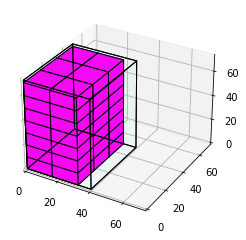

Box Template   16.5 x 16 x 10.25
B07X4WBKJT 1
Image of pallet:  1


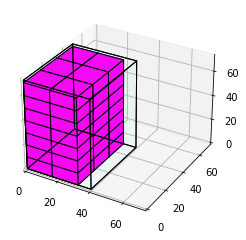

Pallete type view:  2
         ASIN         Box_template  Qty
0  B07X1NXDWM   16.25 x 8.75 x 8.5   16
1  B07X3QM9TW   16.25 x 8.75 x 8.5   20
2  B07Z9LVZD9   16.25 x 8.75 x 8.5   30
3  B07Z9MBNJJ   16.25 x 8.75 x 8.5    2
4  B07Z9MLJP1   16.25 x 8.75 x 8.5   20
5  B093TKY7WB   16.25 x 8.75 x 8.5   20
Image of pallet:  2


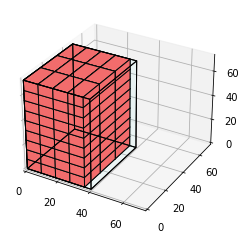

Box Template   16.25 x 8.75 x 8.5
B093TKY7WB 2
Image of pallet:  2


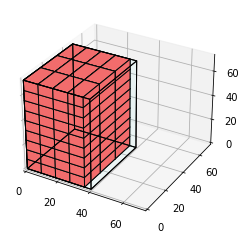

Pallete type view:  3
         ASIN        Box_template  Qty
0  B08FCSY2L5   16.25 x 16 x 9.75   42
Image of pallet:  3


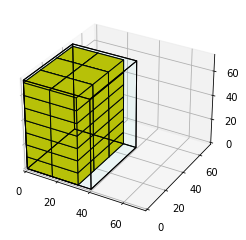

Box Template   16.25 x 16 x 9.75
B08FCSY2L5 3
Image of pallet:  3


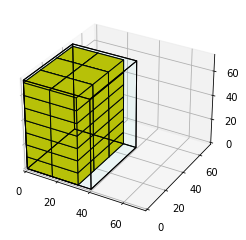

Pallete type view:  4
         ASIN        Box_template  Qty
0  B07X1M8Q6S   16.5 x 16 x 10.25   35
1  B07X4WBKJT   16.5 x 16 x 10.25    7
Image of pallet:  4


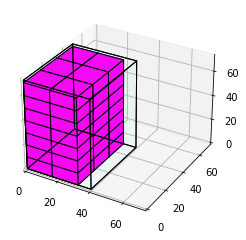

Box Template   16.5 x 16 x 10.25
B07X4WBKJT 4
Image of pallet:  4


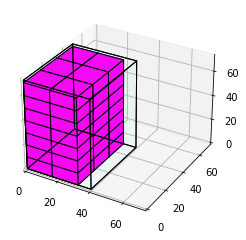

Pallete type view:  5
         ASIN        Box_template  Qty
0  B07X3RYGK5   16.25 x 16 x 9.75   36
1  B07X4VKWKR   16.25 x 16 x 9.75    4
2  B08FCSY2L5   16.25 x 16 x 9.75    2
Image of pallet:  5


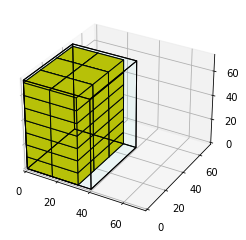

Box Template   16.25 x 16 x 9.75
B08FCSY2L5 5
Image of pallet:  5


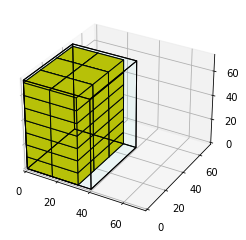

Pallete type view:  6
         ASIN        Box_template  Qty
0  B07X1M8Q6S   16.5 x 16 x 10.25   42
Image of pallet:  6


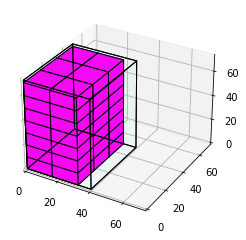

Box Template   16.5 x 16 x 10.25
B07X1M8Q6S 6
Image of pallet:  6


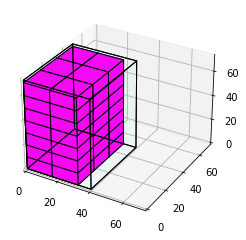

Pallete type view:  7
         ASIN        Box_template  Qty
0  B07X3RYGK5   16.25 x 16 x 9.75    4
1  B0831TD39M        17 x 18 x 19    1
2  B0831TJVKJ        17 x 18 x 19    2
3  B0831TPX4K        17 x 18 x 19    1
4  B0831TVRLY        17 x 18 x 19    1
5  B0831V77FJ        17 x 18 x 19    2
6  B0832B2NFL        17 x 18 x 19    2
7  B0832BC8C1        17 x 18 x 19    1
8  B0832BF87X        17 x 18 x 19    1
9  B0832GTM3K        17 x 18 x 19    1
Image of pallet:  7


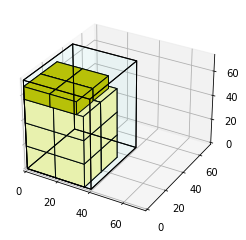

Box Template   17 x 18 x 19
B0832GTM3K 7
Image of pallet:  7


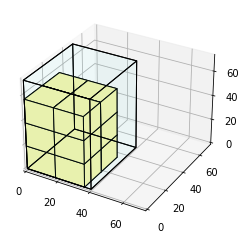

Box Template   16.25 x 16 x 9.75
B07X3RYGK5 7
Image of pallet:  7


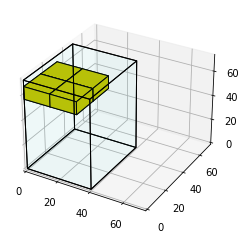

Pallete type view:  8
          ASIN         Box_template  Qty
0   B07WZJZK1X    16.25 x 16 x 9.75    4
1   B07X1M8Q6S    16.5 x 16 x 10.25    1
2   B07X1PHLX9    16.25 x 16 x 9.75    4
3   B07X3RDY9N    16.25 x 16 x 9.75    4
4   B0831SB6BQ         17 x 18 x 19    2
5   B0831SXWSX         17 x 18 x 19    2
6   B0831T4WXH         17 x 18 x 19    2
7   B0831T6H56         17 x 18 x 19    1
8   B0831TCKZ5         17 x 18 x 19    1
9   B0831TD39M         17 x 18 x 19    2
10  B08H4ZD7W1   20.75 x 17.25 x 17    1
Image of pallet:  8


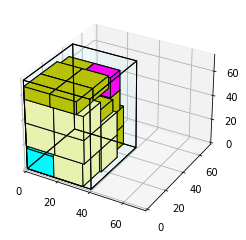

Box Template   20.75 x 17.25 x 17
B08H4ZD7W1 8
Image of pallet:  8


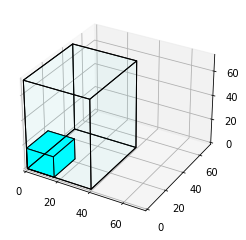

Box Template   17 x 18 x 19
B0831TD39M 8
Image of pallet:  8


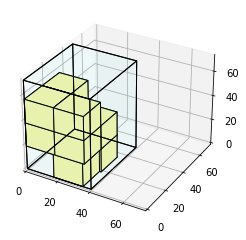

Box Template   16.25 x 16 x 9.75
B07X3RDY9N 8
Image of pallet:  8


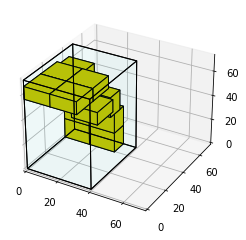

Box Template   16.5 x 16 x 10.25
B07X1M8Q6S 8
Image of pallet:  8


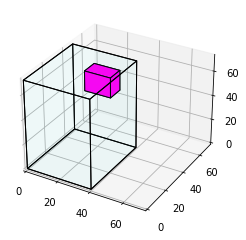

Pallete type view:  9
         ASIN         Box_template  Qty
0  B07X1M8Q6S    16.5 x 16 x 10.25   15
1  B07X1NXDWM   16.25 x 8.75 x 8.5    6
2  B08H4BX3QS   20.75 x 17.25 x 17    2
3  B08H4W3VKG   20.75 x 17.25 x 17    2
4  B08H4ZD7W1   20.75 x 17.25 x 17    1
Image of pallet:  9


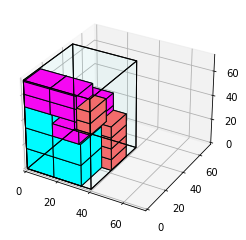

Box Template   20.75 x 17.25 x 17
B08H4ZD7W1 9
Image of pallet:  9


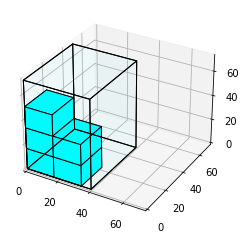

Box Template   16.5 x 16 x 10.25
B07X1M8Q6S 9
Image of pallet:  9


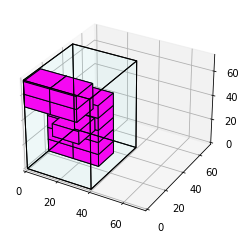

Box Template   16.25 x 8.75 x 8.5
B07X1NXDWM 9
Image of pallet:  9


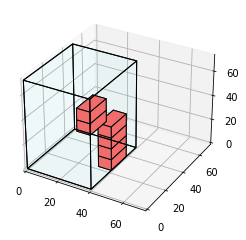

In [5]:
Pallet_W = 40
Pallet_H = 72
Pallet_D = 48
Pallet_max_weight = 1500
packing_df = create_boxes_df_from_sku_df(qty_to_ship)
output = pack_goods_from_df_v3(packing_df, Pallet_W, Pallet_H, Pallet_D, Pallet_max_weight)
make_excel_file(output[0], output[1])

